In [3]:
### GENERATE POCKETVEC DESCRIPRORS FOR 7 MURD STRUCTURES ####

In [4]:
from subprocess import Popen, PIPE
from scipy.spatial import distance
from collections import Counter
import matplotlib.pyplot as plt
from Bio.SeqUtils import seq1
from Bio.PDB import *
from rdkit import Chem
import pandas as pd
import numpy as np
import scipy.stats as ss
import seaborn as sns
import tqdm
import pickle
import os
import time
import shutil
import gzip
import tarfile
import sys
import random
import pybel

In [5]:
path_in = "../data/structures"
path_out = '../pocketvec/MurD/structures/'

sts = ['SagaMurD_Frag349', "SagaMurD_Frag373", "SagaMurD_Frag374", "SagaMurD_Frag378", "SagaMurD_apo", "EColiMurD_substrate", "EColiMurE"]
st_path = os.getcwd()

In [64]:
### PREPARE STRUCTURES FOR DOCKING

In [63]:
for st in sts:
    
    # It takes ~1min/st (substrate takes ~5min)
    
    os.chdir(st_path)
    
    ### FIRST STEPS ###

    path_in = os.path.join("../data/structures", st + ".pdb")
    path_out = os.path.join("../pocketvec/MurD/structures/", st)

    # 1. Make output folder
    if os.path.exists(path_out) is False: os.makedirs(path_out)
    if os.path.exists("../pocketvec/MurD/structures/all") is False: os.makedirs("../pocketvec/MurD/structures/all")
    
    
    # 2. Remove water molecules and ligands (LIG, SO4, EDO, IPA, DMS, CL, EPE)
    parser = PDBParser()
    structure = parser.get_structure("st", path_in)

    shutil.copyfile(path_in, os.path.join(path_out, st + ".pdb"))

    class WaterLIGRemove(Select):
        def accept_residue(self, residue):
            if residue.get_id()[0] not in ["H_SO4", "H_EDO", "H_IPA", "W", "H_DMS", "H_ CL", "H_CL ", "H_EPE", "H_LIG"]:
                return 1
            else:
                return 0

    io = PDBIO()
    io.set_structure(structure)
    io.save(os.path.join(path_out, st + "_water.pdb"), WaterLIGRemove())


    # 3. Remove hydrogens
    command = 'python ../src/check_structure.py -i ' + os.path.join(path_out , st + '_water.pdb') + ' -o ' + os.path.join(path_out , st + '_hydrogens.pdb') + ' --force_save --non_interactive rem_hydrogen --remove Yes'
    o = os.popen(command).read()
    sys.stderr.write(o + "\n\n")
    sys.stderr.flush()

    # 4. Select occupancies
    command = 'python ../src/check_structure.py -i ' + os.path.join(path_out , st + '_hydrogens.pdb') + ' -o ' + os.path.join(path_out , st + '_altloc.pdb') + ' --force_save --non_interactive altloc --select occupancy'
    o = os.popen(command).read()
    sys.stderr.write(o + "\n\n")
    sys.stderr.flush()
    
    
    # 5. Prepare st MOE
    def prepare(infile, prepared_prot, logfile, all_outputs):
        if os.path.isfile(prepared_prot):
            return True, all_outputs
        else:
            moefunct = "../src/moefunctions.svl"
            # PROTEINS ARE PREPARED USING MOE
            process=Popen(["/aloy/home/acomajuncosa/programs/MOE/moe2020/bin/moebatch -load " + moefunct + " -exec \"proteinprep['" + infile + "','" + prepared_prot + "','" + logfile + "']\""],stdout=PIPE,stderr=PIPE,shell=True)
            stdout, stderr = process.communicate()
            sys.stderr.write(str(stdout) + "\n\n")
            sys.stderr.write(str(stderr) + "\n\n")
            all_outputs.append(str(stderr))
        if os.path.isfile(prepared_prot):
            return True, all_outputs
        else:
            return False, all_outputs


    infile = os.path.join(path_out , st + '_altloc.pdb')
    prepared_prot = os.path.join(path_out , st + '_MOEprep.mol2')
    logfile = os.path.join(path_out , st + '_log.log')

    all_outputs = []
    result, all_outputs = prepare(infile, prepared_prot, logfile, all_outputs)
    
    
    # 6. Look for errors
    with open(logfile, "r") as f:
        for l in f:
            if "error" in l.lower():
                print("ERROR WHEN CHECKING LOG FILE! \n\n\n")
                sys.stderr.flush()
                break

    # 7. Tar other files
    os.chdir(path_out)
    tar = tarfile.open(st + "_files.tar.gz", "w:gz")
    files = [st + i for i in ['_water.pdb', "_hydrogens.pdb", "_altloc.pdb", '_log.log']]
    for name in files:
        tar.add(name)
        os.remove(name)
    tar.close()
    
    os.chdir(st_path)
    # 8. Copy to all/ directory
    shutil.copyfile(os.path.join(path_out, st + "_MOEprep.mol2"), os.path.join("../pocketvec/MurD/structures/all", st + "_MOEprep.mol2"))


=                   BioBB structure checking utility v3.0.3                   =
=                 A. Hospital, P. Andrio, J.L. Gelpi 2018-20                  =

Structure ../pocketvec/MurD/structures/SagaMurD_Frag349/SagaMurD_Frag349_water.pdb loaded
 Title: 
 Experimental method: unknown
 Resolution: 0.0 A

 Num. models: 1
 Num. chains: 1 (A: Protein)
 Num. residues:  448
 Num. residues with ins. codes:  0
 Num. HETATM residues:  0
 Num. ligands or modified residues:  0
 Num. water mol.:  0
 Num. atoms:  3416

Running rem_hydrogen. Options: --remove Yes
No residues with Hydrogen atoms found
Structure not modified, saving due to --force_save option
Final Num. models: 1
Final Num. chains: 1 (A: Protein)
Final Num. residues:  448
Final Num. residues with ins. codes:  0
Final Num. HETATM residues:  0
Final Num. ligands or modified residues:  0
Final Num. water mol.:  0
Final Num. atoms:  3416
Structure saved on ../pocketvec/MurD/structures/SagaMurD_Frag349/SagaMurD_Frag349_hydrogens.pdb



In [97]:
### GET THE CONSENUS CENTER OF FRAGMENTS

In [98]:
def get_centroid(file):
    """
    Gets the centroid of a ligand
    """
    
    parser = PDBParser()
    frag = parser.get_structure("st", file)
    coords = np.array([i.get_coord() for i in frag.get_atoms()])
    
    coords = [round(np.mean(coords[:,0]), 3), round(np.mean(coords[:,1]), 3), round(np.mean(coords[:,2]), 3)]
    return coords[0], coords[1], coords[2]


def print_centroid(x, y, z, file_pdb, file_sd):
    """
    Prints de centroid in a file -- pdb format
    """
    
    ctr = " "*(8-len(x)) + x + " "*(8-len(y)) + y + " "*(8-len(z)) + z
    text = """HEADER\nHETATM    1   C  CTR A   1    """ + ctr + """  1.00  1.00           C\nEND"""

    with open(file_pdb, "w") as f:
        f.write(text)

    command = "obabel " + file_pdb + " -O " + file_sd
    os.system(command)

In [99]:
path_in = "../data/structures"
path_out = '../pocketvec/MurD/structures/'

frags = ["373", "374", "378", "349"]
sts = ['SagaMurD_Frag349', "SagaMurD_Frag373", "SagaMurD_Frag374", "SagaMurD_Frag378", "SagaMurD_apo", "EColiMurD_substrate", "EColiMurE"]

ctr = []

for frag in frags:
    x, y, z = get_centroid(os.path.join(path_in, frag + "_ligand_only.pdb"))
    ctr.append([x, y, z])
    
ctr = np.array(ctr)
coords = [round(np.mean(ctr[:,0]), 3), round(np.mean(ctr[:,1]), 3), round(np.mean(ctr[:,2]), 3)]
x, y, z = str(coords[0]), str(coords[1]), str(coords[2])

for st in sts:
    file_pdb = os.path.join(path_out, st, "centroid.pdb")
    file_sd = os.path.join(path_out, st, "centroid.sd")
    print_centroid(x, y, z, file_pdb, file_sd)
    
shutil.copyfile(os.path.join(path_out, st, "centroid.sd"), os.path.join(path_out, "all", "centroid.sd"))

'../pocketvec/MurD/structures/all/centroid.sd'

In [11]:
### COPY DATA TO EXTERNAL LOCATION AND RUN DOCKING CALCULATIONS IN THE CLUSTER ###

In [19]:
path_aloy = "/aloy/home/acomajuncosa/MurD/GitHub/osa-murd/pocketvec/MurD/structures/"
path_sl = "/slgpfs/projects/irb35/acomajuncosa/MurD/structures"
sts = ['SagaMurD_Frag349', "SagaMurD_Frag373", "SagaMurD_Frag374", "SagaMurD_Frag378", "SagaMurD_apo", "EColiMurD_substrate", "EColiMurE"]
lib, elements = 'LLM', []
path_to_lib = "/slgpfs/projects/irb35/acomajuncosa/PocketVec_v2/data/libs/" + lib + "/TOP128_rDock_" + lib + "/ALL/all.sdf"

for st in sts:
    
    if os.path.exists(os.path.join(path_sl, st)) is False: os.makedirs(os.path.join(path_sl, st))
    
    shutil.copy(os.path.join(path_aloy, st, "centroid.sd"), os.path.join(path_sl, st, "centroid.sd"))
    shutil.copy(os.path.join(path_aloy, st, st + "_MOEprep.mol2"), os.path.join(path_sl, st, st + "_MOEprep.mol2"))
    
    path_to_ctr = os.path.join(path_sl, st, "centroid.sd")
    elements.append([st, path_to_lib, lib, path_to_ctr])

In [21]:
import sys
sys.path.insert(0, '/aloy/home/acomajuncosa/programs/hpc') #CHANGE THIS PATH TO YOUR HPC PATH!
from hpc import HPC
from starlife_config import config as cluster_config

scratch_path = "/slgpfs/scratch/irb35/acomajuncosa/MurD/MurD" 
script_path = "/slgpfs/projects/irb35/acomajuncosa/MurD/scripts/gen_fps_rDock_center.py"

ncpus = 1
cluster = HPC(**cluster_config)
njobs = len(elements)

cluster_params = {}
cluster_params['job_name'] = 'murd_murd'
cluster_params["jobdir"] = scratch_path
cluster_params["memory"] = ncpus
cluster_params['cpu'] = ncpus
cluster_params["wait"] = False
cluster_params["elements"] = elements
cluster_params["num_jobs"] = len(elements)


singularity_image = "/slgpfs/projects/irb35/acomajuncosa/rDock_image_2.simg"
command = "singularity exec {} python {} <TASK_ID> <FILE>".format(
singularity_image,
script_path)

cluster.submitMultiJob(command, **cluster_params)

2022-06-04 19:42:37,203 chemicalchecker.util.config.config.Config [DEBUG   ] CC_CONFIG environment variable not set. Using default config file.
2022-06-04 19:42:37,204 chemicalchecker.util.config.config.Config [DEBUG   ] Loading config from: /home/acomajuncosa/programs/anaconda3/lib/python3.7/site-packages/chemicalchecker/util/config/cc_config.json
2022-06-04 19:42:37,705 hpc.HPC      [DEBUG   ] HPC system to use: slurm
2022-06-04 19:42:37,707 hpc.HPC      [DEBUG   ] initializing object slurm


module 'matplotlib.font_manager' has no attribute '_rebuild'


2022-06-04 19:42:37,865 slurm.slurm  [DEBUG   ] Job nasdfdsfsdfsdfdme is: murd_murd
2022-06-04 19:42:37,878 slurm.slurm  [DEBUG   ] Num elements submitted 7
2022-06-04 19:42:37,880 slurm.slurm  [DEBUG   ] Num Job submitted 7
2022-06-04 19:42:37,891 slurm.slurm  [INFO    ] Writing file /slgpfs/scratch/irb35/acomajuncosa/MurD/MurD/job-murd_murd.sh...
2022-06-04 19:42:37,902 slurm.slurm  [DEBUG   ] HPC submission: sbatch --parsable /slgpfs/scratch/irb35/acomajuncosa/MurD/MurD/job-murd_murd.sh
2022-06-04 19:42:41,302 slurm.slurm  [DEBUG   ] load SINGULARITY/3


In [22]:
### COPY RESULTS FROM STARLIFE
path_aloy = "/aloy/home/acomajuncosa/MurD/GitHub/osa-murd/pocketvec/MurD/structures/"
path_sl = "/slgpfs/projects/irb35/acomajuncosa/MurD/structures"
sts = ['SagaMurD_Frag349', "SagaMurD_Frag373", "SagaMurD_Frag374", "SagaMurD_Frag378", "SagaMurD_apo", "EColiMurD_substrate", "EColiMurE"]
lib = 'LLM'

for st in sts:
    source = os.path.join(path_sl, st, "rDock_results_" + lib, "scores")
    dest = os.path.join(path_aloy, st, "scores")
    shutil.copy(source, dest)

In [23]:
### GENERATE POCKET DESCRIPTORS GIVEN DOCKING SCORES ###

In [44]:
def zscore_fp(fp):
    mean = np.mean(fp)
    std = np.std(fp)
    return np.array([(i - mean) / std for i in fp])

def rank_fp(fp_raw):
    # Rank
    fp = ss.rankdata(fp_raw, method='max')
    # Increase ranking for positive scores
    for c in range(len(fp)):
        if fp_raw[c] > 0 and fp_raw[c] < 50:
            fp[c] = len(fp) + 1
        elif fp_raw[c] > 50 and fp_raw[c] < 100:
            fp[c] = len(fp) + 2
        elif fp_raw[c] > 100:
            fp[c] = len(fp) + 3
    return fp
    

def read_scores(file_scores):
    scores = {}
    with open(file_scores, "r") as f:
        for l in f:
            scores[l.split("\t")[0]] = float(l.split("\t")[1])
    return scores

def raw_fp(dict_scores, file_order):
    molecules = pickle.load(open(file_order, "rb"))
    return np.array([dict_scores[i] for i in molecules])

In [50]:
path = "/aloy/home/acomajuncosa/MurD/GitHub/osa-murd/pocketvec/MurD/structures"
sts = ['SagaMurD_Frag349', "SagaMurD_Frag373", "SagaMurD_Frag374", "SagaMurD_Frag378", "SagaMurD_apo", "EColiMurD_substrate", "EColiMurE"]
fps = {}

for st in sts:
    
    # Read scores
    scores = read_scores(os.path.join(path, st, "scores"))
    
    # Raw scores fp
    raw = raw_fp(scores, "../data/PocketVec/lib/LLM/all.pkl")
    pickle.dump(raw, open(os.path.join(path, st, "raw_fp.pkl"), "wb"))
    
    # Rank scores fp
    rank = rank_fp(raw)
    pickle.dump(rank, open(os.path.join(path, st, "rank_fp.pkl"), "wb"))
    
    fps[st] = rank

In [61]:
### PRINT RESULTS
%matplotlib inline

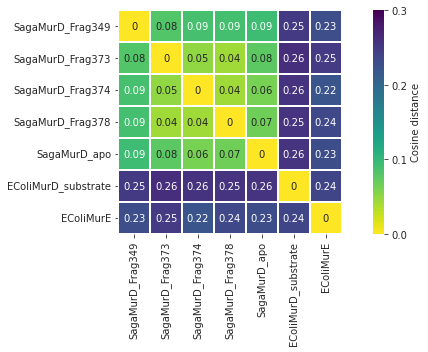

In [66]:
X = []
X_str = []
labels = ['SagaMurD_Frag349', "SagaMurD_Frag373", "SagaMurD_Frag374", "SagaMurD_Frag378", "SagaMurD_apo", "EColiMurD_substrate", "EColiMurE"]

for i in labels:
    x = []
    x_str = []
    for j in labels:
        x.append(distance.cosine(fps[i], fps[j]))
        x_str.append(str(round(distance.cosine(fps[i], fps[j]), 2)))
    X.append(x)
    X_str.append(x_str)
        
X = np.array(X)

fig, ax = plt.subplots(figsize=(9,5)) 
# sns.heatmap(rankings)
sns.heatmap(X, linewidths=2, xticklabels=labels, yticklabels=labels,square=True, cbar=True,
            cmap="viridis_r", annot=X_str, fmt = str(), vmin=0,vmax=0.3,
            cbar_kws={"shrink": 1, 'label':'Cosine distance', 'ticks': [0, 0.1, 0.2, 0.3]},
           annot_kws={"fontsize":10})
plt.yticks(va="center")
plt.tight_layout()
plt.savefig("/aloy/home/acomajuncosa/MurD/GitHub/osa-murd/pocketvec/MurD/images/intraMurD.png", dpi=300)
plt.show()